# Test Notebook to learn how to read in various tide gauge records

### Some sources of tide gauge data

https://www.psmsl.org/

http://www.ioc-sealevelmonitoring.org/

http://uhslc.soest.hawaii.edu/data/

### Load in some modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates

# %matplotlib notebook
%matplotlib inline
# %matplotlib widget

### A place for function development

In [2]:
def read_tidegauge_psmsl(path, columns=None):
    """
    Read and parse PSMSL tide gauge data

    CSV Columns:
        'YEAR', 'MONTH', 'DAY', 'SSH', possibly 'HOUR'

    Parameters
    ----------
    path : str
        Filesystem path to data file
    columns: List

    Returns
    -------
    pandas.DataFrame
        Gravity data indexed by datetime.
    """
    columns = ['YEAR', 'MONTH', 'DAY', 'SSH']

    df = pd.read_csv(path, header=None, engine='c')

#     print(f'len(df.columns): {len(df.columns)}')
#     print(f'len(columns): {len(columns)}')
    
    if len(df.columns) == len(columns):
#         columns += ['unknown']
        df.columns = ['YEAR', 'MONTH', 'DAY', 'SSH']
    else:
        df.columns = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'SSH']
        
    # missing data to NaNs
    df['SSH'] = df['SSH'].replace(-32767, np.nan)
    
    # create datetime index
    dt = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    df.index = pd.DatetimeIndex(dt)
    
    
    return df

In [33]:
dir_in = 'data'
# file_in = 'h820'
file_in = 'd820'
ext = '.csv'

filepath = os.path.join(dir_in, file_in + ext)

df = read_tidegauge_psmsl(filepath)

In [34]:
df.describe()

,YEAR,MONTH,DAY,SSH
count,2158.000000,2158.000000,2158.000000,2005.000000
mean,2016.960612,6.528267,15.760426,4514.105237
std,1.753948,3.476244,8.794916,113.750938
min,2014.000000,1.000000,1.000000,4038.000000
25%,2015.000000,3.000000,8.000000,4444.000000
50%,2017.000000,7.000000,16.000000,4510.000000
75%,2018.000000,10.000000,23.000000,4576.000000
max,2020.000000,12.000000,31.000000,4982.000000


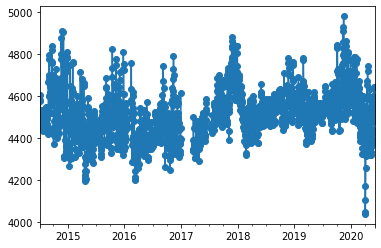

In [35]:
ax = df['SSH'].plot(marker='o')
# ax.set_xlim(pd.Timestamp('2015-08-01'), pd.Timestamp('2015-09-01'))
# ax.set_ylim(4300, 4600)

### Histogram

- What is the mean?
- Is distribution symmetric?

/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dporter/anaconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


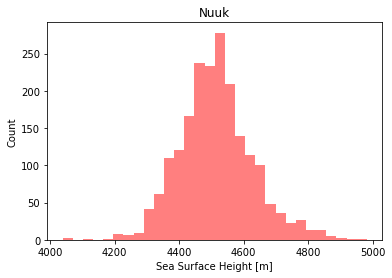

In [24]:
plt.figure(facecolor='white')
plt.hist(df['SSH'], bins=30, alpha=0.5,color='red')
plt.title('Nuuk');
plt.xlabel("Sea Surface Height [m]")
plt.ylabel("Count")
plt.show()

### Plotting using **matplotlib.pyplot** method instead of built-in Pandas
use `plt.plot()`

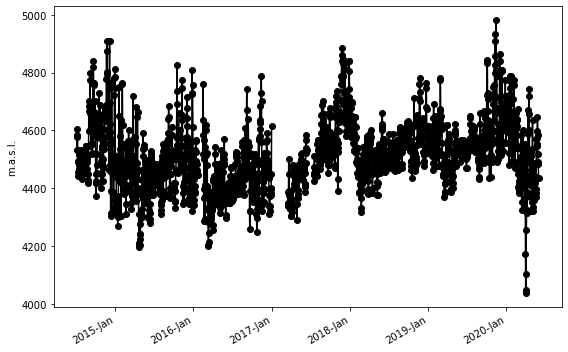

In [25]:
    # Set up
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Plot
ln1 = ax.plot(df['SSH'], '-ok')

# Customize
ax.set_title('')
# ax.set_xlim([my_levels[0], my_levels[-1]])
# ax.set_ylim(my_plotmin, 0)
plt.ylabel('m.a.s.l.')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig(f'figs/')

### Plot each year on top of eachother
Do this by masking by `df.index.year`

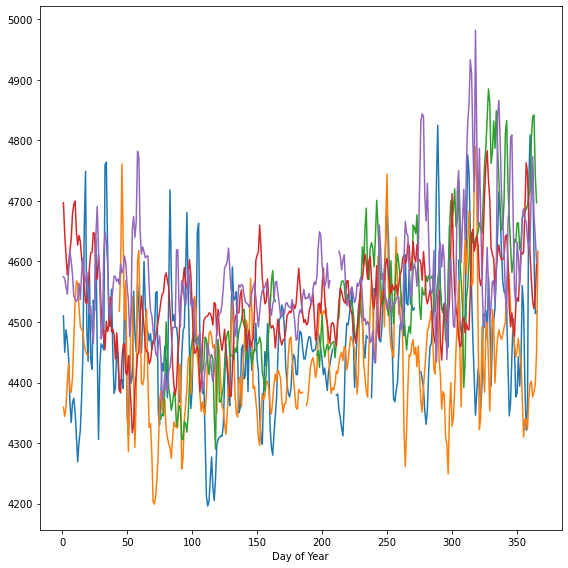

In [26]:
# Set up
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

# Plot
ax.plot(df[df.index.year==2015].index.dayofyear, df[df.index.year==2015]['SSH'])
ax.plot(df[df.index.year==2016].index.dayofyear, df[df.index.year==2016]['SSH'])
ax.plot(df[df.index.year==2017].index.dayofyear, df[df.index.year==2017]['SSH'])
ax.plot(df[df.index.year==2018].index.dayofyear, df[df.index.year==2018]['SSH'])
ax.plot(df[df.index.year==2019].index.dayofyear, df[df.index.year==2019]['SSH'])
# ax.plot(df[df.index.year==2016]['SSH'])
plt.xlabel('Day of Year')
plt.tight_layout()

### Create some climatologies using `groupby` method
Monthly and Daily

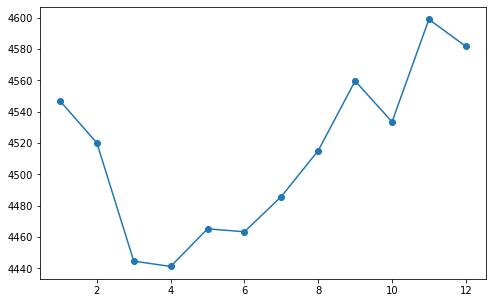

In [30]:
fig = plt.figure(figsize=(8,5))
monthly_climatology = df.groupby(df.index.month).mean()
monthly_climatology.SSH.plot(marker='o')


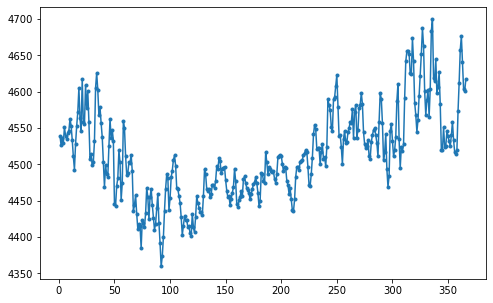

In [28]:
daily_climatology = df.groupby(df.index.dayofyear).mean() #aggregate({'SSH_DAILY_MEAN': 'mean',
#                                                             'SSH_DAILY_MAX': 'max',
#                                                             'SSH_DAILY_MIN': 'min'})
fig = plt.figure(figsize=(8,5))
daily_climatology.SSH.plot(marker='.')

### Standardize
Subtract the mean and divide by standard deviation

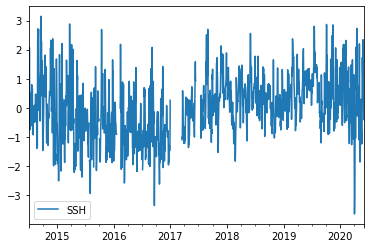

In [29]:
def standardize(x):
    return (x - x.mean())/x.std()

anomaly = df.groupby(df.index.month).transform(standardize)
anomaly.plot(y='SSH')